# Sentiment Analysis of Yelp Reviews

Yelp is a popular platform for user reviews for various brands, especially for restaurants and hotels. This application gathers the reviews for a specific brand in a specific City and by applying Natural Language Processing algorithm, provides Sentiment Analysis graphically.

### Data Sources

The main data source for this Sentiment Analysis program are Yelp APIs. There are 2 APIs that we are accessing here:
- Yelp Businesses API
- Yelp Reviews API


### High-level Approach
1. Prompt for the City where the Yelp reviews need to be pulled for. For example, Atlanta.
2. Prompt for the Brand Name for which the reviews need to be analyzed. For example, Mcdonalds.
3. Using the Yelp Business API, extract the location details of the brand in that city. For example, all Mcdonalds in Atlanta.
4. Then using the Yelp Reviews API, extract all the reviews for each of the locations extracted in Step 3.
5. Using Huggingface and other NLP libraries, perform Sentiment Analysis on the review text.
6. Present a graph of the top ranking Sentiments.

In [1]:
# Import Environment Dependencies
import tweepy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from config import api_key, api_key_secret, access_token,access_token_secret, client_id,\
                    client_secret, tmdb_key, Yelp_Key, Yelp_ID, rds_connection_string,\
                    sqlserver, sqldb, uid, pwd
from pprint import pprint
from emot.emo_unicode import UNICODE_EMOJI
from datetime import date
from datetime import timedelta
from config import gkey
import requests
import urllib
from urllib.request import urlopen
import json
import gmaps
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import pipeline
from scipy.special import softmax
import pyodbc
from sqlalchemy import create_engine
import pymongo
from pymongo import MongoClient
import warnings
warnings.filterwarnings('ignore')
import os.path

In [2]:
# Create a sql server connection string
conn_str = (
    r'DRIVER={SQL Server};'
    r'SERVER='+sqlserver+';'
    r'DATABASE='+sqldb+';'
    r'UID='+uid+';'
    r'PWD='+pwd+';'
)

# Establish a connection
conn = pyodbc.connect(conn_str)

In [3]:
auth_str = 'Bearer '+ Yelp_Key 
import re

## Step 1 - Input Brand & City and Extract Brand Locations
- Prompt and get City and Brand to be analyzed
- Use Yelp Business API to extract all brand locations in the city
- Add these to a Panda Dataframe

In [4]:
stores = []

print("Enter City Name")
city = input()

city = city.upper()

print("Enter Brand Name")
brand = input()

brand = brand.upper()

url = "https://api.yelp.com/v3/businesses/search?location="

query_url = url + city + "&term="+ brand+"&sort_by=best_match&limit=30"

headers = {
    "accept": "application/json",
    "Authorization": auth_str
}

response = requests.get(query_url, headers=headers)

response_json = response.json()
try:
            i = 0
            for r in response_json['businesses']:
                sname = response_json['businesses'][i]['name']
                sname = sname.upper()
                if (len(response_json['businesses'][i]['alias']) > 0) and re.search(brand, sname):
                    Store_Name = response_json['businesses'][i]['alias']
                    Store_Chain_Name = response_json['businesses'][i]['name']
                    Store_Lat = response_json['businesses'][i]['coordinates']['latitude']
                    Store_Long = response_json['businesses'][i]['coordinates']['longitude']
                    Store_City = city.title()
                    current_record = [Store_Name, Store_Lat, Store_Long, Store_Chain_Name, Store_City]
                    stores.append(current_record)
        
                i = i + 1

except IndexError:
        errors.append('Index Out of Range')    
    
storedf = pd.DataFrame(stores, columns=['Store_Name','Store_Lat', 'Store_Long','Store_Chain_Name', 'Store_City'])

storedf = storedf.sort_values(by="Store_Name")
storedf

Enter City Name
San Diego
Enter Brand Name
Chipotle


,Store_Name,Store_Lat,Store_Long,Store_Chain_Name,Store_City
19,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,Chipotle Mexican Grill,San Diego
16,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,Chipotle Mexican Grill,San Diego
23,chipotle-mexican-grill-chula-vista-8,32.647115,-116.965626,Chipotle Mexican Grill,San Diego
21,chipotle-mexican-grill-del-mar,32.981287,-117.249798,Chipotle Mexican Grill,San Diego
17,chipotle-mexican-grill-el-cajon-2,32.794036,-116.934819,Chipotle Mexican Grill,San Diego
22,chipotle-mexican-grill-imperial-beach,32.583636,-117.115578,Chipotle Mexican Grill,San Diego
10,chipotle-mexican-grill-la-jolla-2,32.865734,-117.232143,Chipotle Mexican Grill,San Diego
11,chipotle-mexican-grill-la-mesa,32.773605,-117.026960,Chipotle Mexican Grill,San Diego
13,chipotle-mexican-grill-national-city-4,32.660528,-117.105534,Chipotle Mexican Grill,San Diego
18,chipotle-mexican-grill-poway,32.954906,-117.038904,Chipotle Mexican Grill,San Diego


## Step 2 - Extract Reviews 
- Use Yelp Review API to extract and display Star Rating and Review Text of the brand locations
- Add these to a Panda Dataframe

In [5]:
store_reviews = []

for row in storedf.itertuples():
    
    store_name = row.Store_Name
    store_lat = row.Store_Lat
    store_long = row.Store_Long
    store_chain_name = row.Store_Chain_Name 
    store_city = row.Store_City
    
    url = "https://api.yelp.com/v3/businesses/"
    
    query_url = url + store_name+ "/reviews?limit=50&sort_by=yelp_sort"

    headers = {
        "accept": "application/json",
        "Authorization": auth_str
    }

    
    response = requests.get(query_url, headers=headers)

    response_json = response.json()
    

    try:
                i = 0
                for r in response_json['reviews']:
                    if len(response_json['reviews'][i]['text']) > 0:
                        Store_Name = store_name
                        Store_Lat = store_lat
                        Store_Long = store_long
                        Store_Chain_Name = store_chain_name
                        Store_City = store_city
                        Store_Review = response_json['reviews'][i]['text']
                        Store_Star_Rating = response_json['reviews'][i]['rating']
                        current_record = [Store_Name, Store_Lat, Store_Long, Store_City,\
                                               Store_Chain_Name, Store_Star_Rating, Store_Review]
                        store_reviews.append(current_record)

                    i = i + 1

    except IndexError:
            errors.append('Index Out of Range')    

reviewdf = pd.DataFrame(store_reviews, columns=['Store_Name','Store_Lat', 'Store_Long','Store_City',\
                                                    'Store_Chain_Name','Store_Star_Rating','Store_Review'])

reviewdf = reviewdf.sort_values(by="Store_Name")
reviewdf

,Store_Name,Store_Lat,Store_Long,Store_City,Store_Chain_Name,Store_Star_Rating,Store_Review
0,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,5,One of my favorite place to eat \nManager and ...
1,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,4,I've been to this location 3 times over the pa...
2,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,1,Poor customer service. Over charged and gave s...
3,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,3,Great fast food but $30 for three tacos that's...
4,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,4,Usually I get a salad but today I decided to g...
...,...,...,...,...,...,...,...
70,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,2,I'm here about once a week. Either I'm super ...
71,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,1,I always have a problem ordering a quesadilla ...
73,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,1,"""Yeah, we'll, we're a busy store!""\nThis was l..."
72,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,4,Fantastic food. Great atmosphere. The location...


## Step 3 - Analyze Review Text and Assign Sentiment Score
- SentimentIntensistyAnalyzer function from the NTLK libraries is used assign a score based on the verbiage of the Review text.
- Depending on if the Score is > 0, Equal to 0 or < 0, we determine the Score Category as Positive, Neutral or Negative.
- The Score and the Score Category are added as columns to the dataframe.

In [6]:
sid = SentimentIntensityAnalyzer()
list1 = []
for i in reviewdf['Store_Review']:
    list1.append((sid.polarity_scores(str(i)))['compound'])

In [7]:
reviewdf['sentiment_vader'] = pd.Series(list1)

def sentiment_category(sentiment):
    label = ''
    if(sentiment>0):
        label = 'positive'
    elif(sentiment == 0):
        label = 'neutral'
    else:
        label = 'negative'
    return(label)

reviewdf['sentiment_category_vader'] = reviewdf['sentiment_vader'].apply(sentiment_category)

In [8]:
reviewdf

,Store_Name,Store_Lat,Store_Long,Store_City,Store_Chain_Name,Store_Star_Rating,Store_Review,sentiment_vader,sentiment_category_vader
0,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,5,One of my favorite place to eat \nManager and ...,0.8225,positive
1,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,4,I've been to this location 3 times over the pa...,0.8126,positive
2,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,1,Poor customer service. Over charged and gave s...,-0.8316,negative
3,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,3,Great fast food but $30 for three tacos that's...,-0.2144,negative
4,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,4,Usually I get a salad but today I decided to g...,0.0000,neutral
...,...,...,...,...,...,...,...,...,...
70,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,2,I'm here about once a week. Either I'm super ...,0.2516,positive
71,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,1,I always have a problem ordering a quesadilla ...,-0.6705,negative
73,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,1,"""Yeah, we'll, we're a busy store!""\nThis was l...",0.9690,positive
72,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,4,Fantastic food. Great atmosphere. The location...,-0.4293,negative


## Step 4 - Analyze Review Text Using BERT Model
- Using the Cardiff NLP model analyze the Review text and assign a Positive, Negative and Neutral score to it. 
- This is BERT (Bidirectional Encoder Representations from Transformers) and is trained on over 50M Tweets

In [9]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [10]:
scores = []
for i in reviewdf['Store_Review']:
    encoded_text = tokenizer(i, return_tensors='pt')
    output = model(**encoded_text)
    score = output[0][0].detach().numpy()
    score = softmax(score)
    scores_dict = {
        'roberta_neg' : score[0],
        'roberta_neu' : score[1],
        'roberta_pos' : score[2],
    }
    scores.append(scores_dict)

In [11]:
roberta_neg=[]
roberta_neu=[]
roberta_pos=[]

for i in scores:
    neg = i['roberta_neg']
    neu = i['roberta_neu']
    pos = i['roberta_pos']
    roberta_neg.append(neg)
    roberta_neu.append(neu)
    roberta_pos.append(pos)
    
reviewdf['roberta_neg'] = pd.Series(roberta_neg)
reviewdf['roberta_neu'] = pd.Series(roberta_neu)
reviewdf['roberta_pos'] = pd.Series(roberta_pos)

In [12]:
reviewdf

,Store_Name,Store_Lat,Store_Long,Store_City,Store_Chain_Name,Store_Star_Rating,Store_Review,sentiment_vader,sentiment_category_vader,roberta_neg,roberta_neu,roberta_pos
0,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,5,One of my favorite place to eat \nManager and ...,0.8225,positive,0.002571,0.016051,0.981377
1,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,4,I've been to this location 3 times over the pa...,0.8126,positive,0.002505,0.010440,0.987055
2,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,1,Poor customer service. Over charged and gave s...,-0.8316,negative,0.965136,0.031719,0.003144
3,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,3,Great fast food but $30 for three tacos that's...,-0.2144,negative,0.441319,0.357684,0.200996
4,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,4,Usually I get a salad but today I decided to g...,0.0000,neutral,0.339145,0.601636,0.059219
...,...,...,...,...,...,...,...,...,...,...,...,...
70,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,2,I'm here about once a week. Either I'm super ...,0.2516,positive,0.908224,0.082973,0.008803
71,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,1,I always have a problem ordering a quesadilla ...,-0.6705,negative,0.926338,0.067533,0.006130
73,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,1,"""Yeah, we'll, we're a busy store!""\nThis was l...",0.9690,positive,0.001691,0.006683,0.991626
72,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,4,Fantastic food. Great atmosphere. The location...,-0.4293,negative,0.673551,0.268306,0.058143


## Step 5 - Find Underlying Emotion beneath the Review
- Using another BERT Model arpanghoshal/EmoRoBERTa to get the emotion/sentiment in the Review text.
- This model has been trained using Reddit comments
- It helps identify emotions such as - admiration, amusement, disapproval, disgust, relief etc. and even a Neutral emotion.
- This emotion is added as another column to the dataframe

In [13]:
tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [14]:
def get_emotion_label(text):
  return(emotion(text)[0]['label'])

In [15]:
reviewdf['Emotion'] = reviewdf['Store_Review'].apply(get_emotion_label)

In [16]:
reviewdf

,Store_Name,Store_Lat,Store_Long,Store_City,Store_Chain_Name,Store_Star_Rating,Store_Review,sentiment_vader,sentiment_category_vader,roberta_neg,roberta_neu,roberta_pos,Emotion
0,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,5,One of my favorite place to eat \nManager and ...,0.8225,positive,0.002571,0.016051,0.981377,admiration
1,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,4,I've been to this location 3 times over the pa...,0.8126,positive,0.002505,0.010440,0.987055,admiration
2,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,1,Poor customer service. Over charged and gave s...,-0.8316,negative,0.965136,0.031719,0.003144,disappointment
3,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,3,Great fast food but $30 for three tacos that's...,-0.2144,negative,0.441319,0.357684,0.200996,admiration
4,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,4,Usually I get a salad but today I decided to g...,0.0000,neutral,0.339145,0.601636,0.059219,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,2,I'm here about once a week. Either I'm super ...,0.2516,positive,0.908224,0.082973,0.008803,disapproval
71,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,1,I always have a problem ordering a quesadilla ...,-0.6705,negative,0.926338,0.067533,0.006130,neutral
73,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,1,"""Yeah, we'll, we're a busy store!""\nThis was l...",0.9690,positive,0.001691,0.006683,0.991626,neutral
72,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,4,Fantastic food. Great atmosphere. The location...,-0.4293,negative,0.673551,0.268306,0.058143,admiration


## Step 6 - Filter Out Neutral Reviews
- To ensure that we don't clutter the Sentiment Analysis with a bunch of Neutral Reviews, we filter those out.

In [17]:
finalreviewdf = reviewdf[reviewdf["Emotion"] != 'neutral'] 
finalreviewdf

,Store_Name,Store_Lat,Store_Long,Store_City,Store_Chain_Name,Store_Star_Rating,Store_Review,sentiment_vader,sentiment_category_vader,roberta_neg,roberta_neu,roberta_pos,Emotion
0,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,5,One of my favorite place to eat \nManager and ...,0.8225,positive,0.002571,0.016051,0.981377,admiration
1,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,4,I've been to this location 3 times over the pa...,0.8126,positive,0.002505,0.010440,0.987055,admiration
2,chipotle-mexican-grill-chula-vista,32.646146,-117.002586,San Diego,Chipotle Mexican Grill,1,Poor customer service. Over charged and gave s...,-0.8316,negative,0.965136,0.031719,0.003144,disappointment
3,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,3,Great fast food but $30 for three tacos that's...,-0.2144,negative,0.441319,0.357684,0.200996,admiration
5,chipotle-mexican-grill-chula-vista-3,32.631538,-117.088096,San Diego,Chipotle Mexican Grill,1,As soon as we entered we were greeted with att...,-0.2944,negative,0.784929,0.200062,0.015009,annoyance
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,chipotle-mexican-grill-san-diego-6,32.979569,-117.082581,San Diego,Chipotle Mexican Grill,3,This review is specific to the Carmel Mountain...,0.1779,positive,0.017846,0.170807,0.811348,admiration
67,chipotle-mexican-grill-san-diego-6,32.979569,-117.082581,San Diego,Chipotle Mexican Grill,1,Worst location ever !!!\n\nThey always unorgan...,-0.7163,negative,0.943326,0.050189,0.006486,disgust
70,chipotle-mexican-grill-san-diego-9,33.020140,-117.111070,San Diego,Chipotle Mexican Grill,2,I'm here about once a week. Either I'm super ...,0.2516,positive,0.908224,0.082973,0.008803,disapproval
72,chipotle-mexican-grill-santee-2,32.841021,-116.981412,San Diego,Chipotle Mexican Grill,4,Fantastic food. Great atmosphere. The location...,-0.4293,negative,0.673551,0.268306,0.058143,admiration


In [18]:
# Assign Overall Positive or Negative Sentiment Values to each review in the dataframe
conditions = [
    (finalreviewdf['roberta_pos'] > finalreviewdf['roberta_neg']),
    (finalreviewdf['roberta_pos'] < finalreviewdf['roberta_neg'])]
choices = ['positive', 'negative']
finalreviewdf['sentiment_type'] = np.select(conditions,choices, default='neutral')

## Step 7 - Plot Graph of Sentiments
- Plot a bar chart showing the Sentiments by Review Count
- The bar chart is sorted in the descending order of Number of Reviews
- The Sentiment with the highest number of Reviews is on the top.
- We can also generate a pie chart showing the distribution of the emotions across the reviews 

### Bar Chart

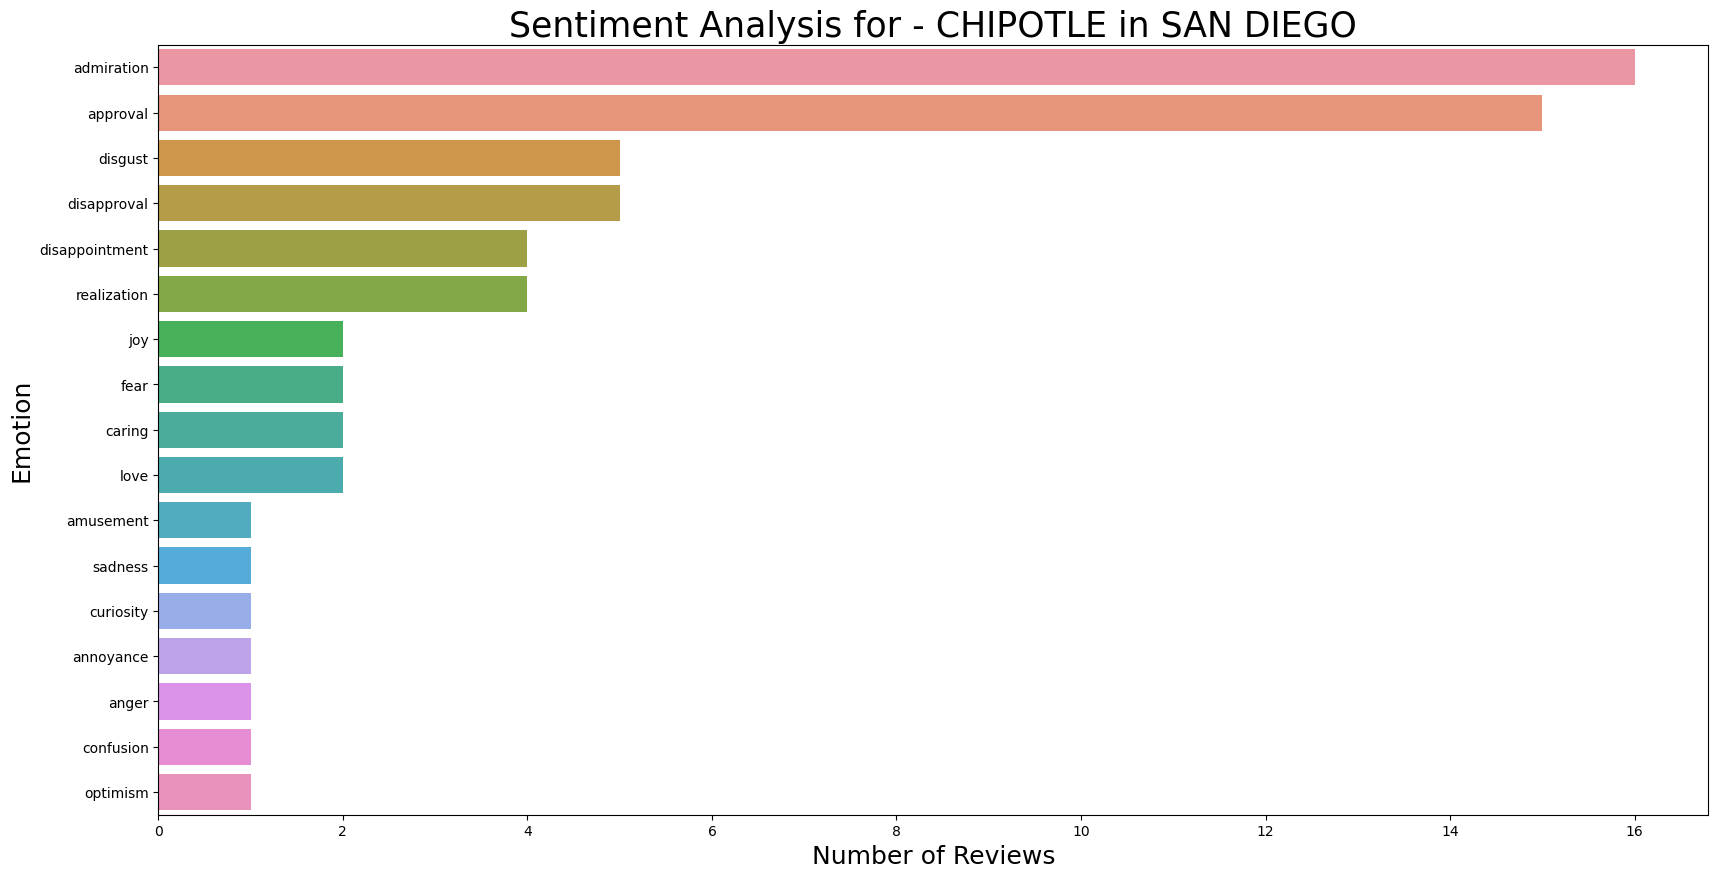

In [19]:
plt.figure(figsize = (20,10))
ax= sns.countplot(data = finalreviewdf, y = 'Emotion', order = finalreviewdf['Emotion'].value_counts().index)
ax.set_title("Sentiment Analysis for - "+ brand +" in "+city, fontsize = 25)
# ax.set_title("Sentiment Analysis for - Any_Brand in Any_City", fontsize = 25)
plt.xlabel("Number of Reviews",fontsize=18)
plt.ylabel("Emotion", fontsize=18)
plt.show()

### Pie Chart

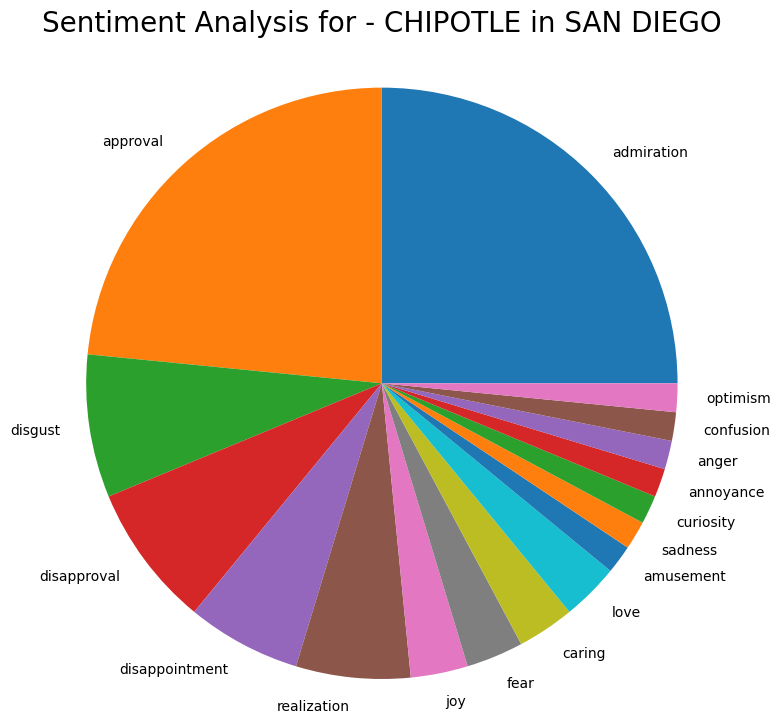

In [20]:
plt.title(label ="Sentiment Analysis for - "+ brand +" in "+city, fontdict={"fontsize":20},pad=120)

# plt.title(label ="Sentiment Analysis for - Any_Brand in Any_City", fontdict={"fontsize":20},pad=120)

plt.pie(finalreviewdf['Emotion'].value_counts(), labels = finalreviewdf['Emotion'].value_counts().index, radius = 2)

plt.show()

## Step 8 - Save the Sentiment Analysis Data in CSV and a SQL Server Database
- Save the Dataframe with the Sentiment Analysis to CSV file and a SQL Server Table for future analytics
- The program first checks if the CSV file exists if it does the data is Appended else the file is created.
- The program then checks if there is a Table called Sentiment_Analysis and if not creates the table else appends the rows.

In [21]:
file_name = 'yelp_reviews_sentiment.csv'

check_file = os.path.isfile(file_name)

if check_file == True:
    finalreviewdf.to_csv(file_name, mode= 'a', sep=',', index=False, header=False)
else:
    finalreviewdf.to_csv(file_name, sep=',', index=False)    

In [22]:
# Create SQLAlchemy engine to connect to SQL Server
engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(conn_str))

In [23]:
# Write rows from the dataframe to SQL Table
finalreviewdf.to_sql('Sentiment_Analysis', engine, if_exists='append', index=False)

-1

## Step 9 - Save the Sentiment Analysis Data in MongoDB 
- Save the Dataframe with the Sentiment Analysis to a MongoDB Database Collection

In [24]:
# Create connect string to MongoDB
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [25]:
# Convert dataframe into a Dictionary
finalreviewdf_dict = finalreviewdf.to_dict("records")
finalreviewdf_dict

[{'Store_Name': 'chipotle-mexican-grill-chula-vista',
  'Store_Lat': 32.6461461339356,
  'Store_Long': -117.002586105488,
  'Store_City': 'San Diego',
  'Store_Chain_Name': 'Chipotle Mexican Grill',
  'Store_Star_Rating': 5,
  'Store_Review': 'One of my favorite place to eat \nManager and staff always looking to help customer even on rushing hours \nThey do a good job with the cleaning \nAnd food is...',
  'sentiment_vader': 0.8225,
  'sentiment_category_vader': 'positive',
  'roberta_neg': 0.002571484772488475,
  'roberta_neu': 0.01605149172246456,
  'roberta_pos': 0.9813770651817322,
  'Emotion': 'admiration',
  'sentiment_type': 'positive'},
 {'Store_Name': 'chipotle-mexican-grill-chula-vista',
  'Store_Lat': 32.6461461339356,
  'Store_Long': -117.002586105488,
  'Store_City': 'San Diego',
  'Store_Chain_Name': 'Chipotle Mexican Grill',
  'Store_Star_Rating': 4,
  'Store_Review': "I've been to this location 3 times over the past two weeks and the customer service is on point. Love w

In [26]:
# Define the 'sentia' database in MongoDB
db = client.sentia

In [27]:
# Create a Collection yelpreviews in the Sentia DB
yelpreview = db.yelpreviews

In [28]:
# Insert records from finalreviewdf_dict Dictionary into MongoDB Collection
yelpreview.insert_many(finalreviewdf_dict)